In [2]:
import os
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt
import sweetviz as sv
import numpy as np
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold
from sklearn.metrics import roc_auc_score, roc_curve, r2_score
from scipy.stats import spearmanr, pearsonr

In [3]:
os.chdir('./scripts')

import load_config

In [4]:
config = load_config.load_config_const()
plt.style.use('seaborn')

# Obtención de serie temporal de traspasos diarios de turismos

El objetivo de este notebook es crear una serie temporal en la que se calcule el número de traspasos de turismos. Primero realizaremos la carga del dataframe con una función que ya nos dará muchos de los campos formateados del notebook anterior

In [5]:
df_dgt = load_config.obtain_dgt_dataset(config, 0.4)
df_dgt.sample(10)

Processing export_anual_trf_2015.csv.tar.gz
### Lines -> 902028
### Create main datagrame
### Total lines -> 902028
Processing export_anual_trf_2016.csv.tar.gz
### Lines -> 981216
### Merge with main datagrame
### Total lines -> 1883244
Processing export_anual_trf_2017.csv.tar.gz
### Lines -> 1095109
### Merge with main datagrame
### Total lines -> 2978353
Processing export_anual_trf_2018.csv.tar.gz
### Lines -> 1171815
### Merge with main datagrame
### Total lines -> 4150168
Processing export_anual_trf_2019.csv.tar.gz
### Lines -> 1186271
### Merge with main datagrame
### Total lines -> 5336439
Processing export_anual_trf_2020.csv.tar.gz
### Lines -> 1003365
### Merge with main datagrame
### Total lines -> 6339804
Processing export_anual_trf_2021.csv.tar.gz
### Lines -> 1118990
### Merge with main datagrame
### Total lines -> 7458794


,FEC_MATRICULA,COD_CLASE_MAT,FEC_TRAMITACION,MARCA_ITV,MODELO_ITV,COD_PROCEDENCIA_ITV,COD_PROPULSION_ITV,CILINDRADA_ITV,POTENCIA_ITV,NUM_PLAZAS,...,NIVEL_EMISIONES_EURO_ITV,CONSUMO_WH/KM_ITV,CATEGORÍA_VEHÍCULO_ELÉCTRICO,AUTONOMÍA_VEHÍCULO_ELÉCTRICO,year_Q,Q_query,ID_MUNICIPIO,month_year_Q,day_of_week,is_weekend
1163734,2006-07-14,0.0,2018-05-30,OPEL,CORSA,0.0,1.0,1248,10.02,5,...,EURO 4,0.0,NaN,NaN,2018,2,28,5,Wednesday,False
793170,2004-06-23,0.0,2021-04-20,OPEL,ASTRA,3.0,0,1598,11.63,5,...,EURO 3,0.0,NaN,NaN,2021,2,30,4,Tuesday,False
1118702,2000-03-29,0.0,2015-12-23,VOLKSWAGEN,POLO 1.9 SDI 5V,0.0,1,1896,12.89,5,...,EURO 2,0.0,NaN,NaN,2015,3,36,7,Wednesday,False
1503899,1997-12-02,0.0,2015-09-15,MERCEDES-BENZ,190 2.3,1.0,0.0,2298,14.48,5,...,EURO 2,0.0,NaN,NaN,2015,3,38,9,Tuesday,False
1918503,2010-06-09,0.0,2020-11-05,PEUGEOT,207 5P CONFORT 1,3.0,0.0,1397,10.74,5,...,EURO 4,0.0,NaN,NaN,2020,4,21,10,Thursday,False
557764,2004-11-30,0.0,2015-04-07,RENAULT,CLIO,3.0,1,1461,11.02,5,...,EURO 3,0.0,NaN,NaN,2015,2,28,4,Tuesday,False
1142867,2001-08-07,0.0,2019-05-24,FORD,MONDEO,3.0,0,2495,17.88,5,...,EURO 3,0.0,NaN,NaN,2019,2,13,5,Friday,False
2151457,2003-10-08,0.0,2020-11-19,FORD,FIESTA,0.0,0.0,1299,10.27,5,...,EURO 3,0.0,NaN,NaN,2020,4,28,11,Thursday,False
2206812,2004-07-14,0.0,2021-10-20,VOLKSWAGEN,GOLF 1.9,3.0,1,1896,12.89,5,...,EURO 3,0.0,NaN,NaN,2021,4,33,10,Wednesday,False
565503,2008-07-02,0.0,2015-04-08,CITROEN,C1 1.0,0.0,0,998,7.82,4,...,EURO 4,0.0,NaN,NaN,2015,2,38,4,Wednesday,False


El siguiente paso es agrupar todas las transacciones por las fechas en las que se producen. Esto nos dará la cuantía diaria de trasacciones

In [6]:
temporal_df_dgt = df_dgt.groupby(["FEC_TRAMITE"]).size().reset_index(name='count')

In [7]:
temporal_df_dgt.sort_values('FEC_TRAMITE', ascending=True)

,FEC_TRAMITE,count
0,2015-01-01,1
1,2015-01-02,1044
2,2015-01-03,4
3,2015-01-04,39
4,2015-01-05,1583
...,...,...
2418,2021-12-27,7357
2419,2021-12-28,6419
2420,2021-12-29,7365
2421,2021-12-30,7249


Crearemos un nuevo campo para la fecha, ya que el objetivo es usarla como indice para ordenar el dataframa

In [8]:
temporal_df_dgt['date'] = temporal_df_dgt['FEC_TRAMITE']
temporal_df_dgt

,FEC_TRAMITE,count,date
0,2015-01-01,1,2015-01-01
1,2015-01-02,1044,2015-01-02
2,2015-01-03,4,2015-01-03
3,2015-01-04,39,2015-01-04
4,2015-01-05,1583,2015-01-05
...,...,...,...
2418,2021-12-27,7357,2021-12-27
2419,2021-12-28,6419,2021-12-28
2420,2021-12-29,7365,2021-12-29
2421,2021-12-30,7249,2021-12-30


In [9]:
temporal_df_dgt = temporal_df_dgt.set_index('FEC_TRAMITE')

In [10]:
temporal_df_dgt

,count,date
FEC_TRAMITE,,
2015-01-01,1,2015-01-01
2015-01-02,1044,2015-01-02
2015-01-03,4,2015-01-03
2015-01-04,39,2015-01-04
2015-01-05,1583,2015-01-05
...,...,...
2021-12-27,7357,2021-12-27
2021-12-28,6419,2021-12-28
2021-12-29,7365,2021-12-29


Mediante la siguiente linea de código, obtendremos las fechas en las cuales no tenemos registros de trasacciones (lo que interrumpiría la serie temporal)

In [11]:
idx = pd.date_range(start = temporal_df_dgt["date"].min(), end = temporal_df_dgt["date"].max() , freq="d").difference(temporal_df_dgt["date"])

In [12]:
idx

DatetimeIndex(['2015-02-28', '2015-03-29', '2015-04-05', '2015-07-11',
               '2015-08-09', '2015-09-05', '2015-09-27', '2015-11-08',
               '2015-11-21', '2015-11-29',
               ...
               '2019-12-07', '2020-01-01', '2020-01-18', '2020-02-01',
               '2020-02-09', '2020-02-16', '2020-02-22', '2020-03-01',
               '2020-03-15', '2020-04-11'],
              dtype='datetime64[ns]', length=134, freq=None)

In [13]:
temporal_df_dgt_no_data = pd.DataFrame({'FEC_TRAMITE': idx})
temporal_df_dgt_no_data

,FEC_TRAMITE
0,2015-02-28
1,2015-03-29
2,2015-04-05
3,2015-07-11
4,2015-08-09
...,...
129,2020-02-16
130,2020-02-22
131,2020-03-01
132,2020-03-15


A partir de estas fechas obtendremos un nuevo dataframe, el cual iremos rellenando con las columnas de nuestro dataframe original

In [14]:
temporal_df_dgt_no_data['date'] = temporal_df_dgt_no_data['FEC_TRAMITE']
temporal_df_dgt_no_data

,FEC_TRAMITE,date
0,2015-02-28,2015-02-28
1,2015-03-29,2015-03-29
2,2015-04-05,2015-04-05
3,2015-07-11,2015-07-11
4,2015-08-09,2015-08-09
...,...,...
129,2020-02-16,2020-02-16
130,2020-02-22,2020-02-22
131,2020-03-01,2020-03-01
132,2020-03-15,2020-03-15


In [15]:
temporal_df_dgt_no_data['count'] = 0
temporal_df_dgt_no_data

,FEC_TRAMITE,date,count
0,2015-02-28,2015-02-28,0
1,2015-03-29,2015-03-29,0
2,2015-04-05,2015-04-05,0
3,2015-07-11,2015-07-11,0
4,2015-08-09,2015-08-09,0
...,...,...,...
129,2020-02-16,2020-02-16,0
130,2020-02-22,2020-02-22,0
131,2020-03-01,2020-03-01,0
132,2020-03-15,2020-03-15,0


Ya que en principio no tenemos datos de las ventas, indicamos que han sido 0, luego les daremos un valor

In [16]:
temporal_df_dgt_no_data = temporal_df_dgt_no_data.set_index('FEC_TRAMITE')
temporal_df_dgt_no_data

,date,count
FEC_TRAMITE,,
2015-02-28,2015-02-28,0
2015-03-29,2015-03-29,0
2015-04-05,2015-04-05,0
2015-07-11,2015-07-11,0
2015-08-09,2015-08-09,0
...,...,...
2020-02-16,2020-02-16,0
2020-02-22,2020-02-22,0
2020-03-01,2020-03-01,0


Luego te tener nuestro nuevo dataframe con las fechas sin datos, lo concatenaremos a nuestro dataset original

In [17]:
frames = [temporal_df_dgt, temporal_df_dgt_no_data]

result_dgt = pd.concat(frames)

In [18]:
result_dgt.sort_values('date', ascending=False)

,count,date
FEC_TRAMITE,,
2021-12-31,13,2021-12-31
2021-12-30,7249,2021-12-30
2021-12-29,7365,2021-12-29
2021-12-28,6419,2021-12-28
2021-12-27,7357,2021-12-27
...,...,...
2015-01-05,1583,2015-01-05
2015-01-04,39,2015-01-04
2015-01-03,4,2015-01-03


Indicaremos que días son fin de semana frente a los días ordinarios

In [19]:
def is_weekend(day_week):
    if (day_week == 'Saturday' or day_week == 'Sunday'):
        return 1.0
    else:
        return 0.0
    return False

In [20]:
result_dgt['is_weekend'] = result_dgt['date'].dt.day_name().apply(lambda x: is_weekend(x))

In [21]:
result_dgt.sort_values('date', ascending=True)

,count,date,is_weekend
FEC_TRAMITE,,,
2015-01-01,1,2015-01-01,0.0
2015-01-02,1044,2015-01-02,0.0
2015-01-03,4,2015-01-03,1.0
2015-01-04,39,2015-01-04,1.0
2015-01-05,1583,2015-01-05,0.0
...,...,...,...
2021-12-27,7357,2021-12-27,0.0
2021-12-28,6419,2021-12-28,0.0
2021-12-29,7365,2021-12-29,0.0


Añadiremos nuevos campos para indicar los ciclos de semanas, meses y años. Tal como vimos en el notebook anterior, es importante recalcar estos periodos, ya que condicionan los traspasos y su frecuencia 

In [22]:
x = np.arange(len(result_dgt))

result_dgt["s_period_week"] = np.sin(2*np.pi*x/7)
result_dgt["s_period_month"] = np.sin(2*np.pi*x/30.5)
result_dgt["s_period_year"] = np.sin(2*np.pi*x/365 )

result_dgt["c_period_week"] = np.cos(2*np.pi*x/7)
result_dgt["c_period_month"] = np.cos(2*np.pi*x/30.5)
result_dgt["c_period_year"] = np.cos(2*np.pi*x/365 )

In [23]:
result_dgt.sort_values('date', ascending=True)

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,
2015-01-01,1,2015-01-01,0.0,0.000000e+00,0.000000,0.000000,1.000000,1.000000,1.000000
2015-01-02,1044,2015-01-02,0.0,7.818315e-01,0.204552,0.017213,0.623490,0.978856,0.999852
2015-01-03,4,2015-01-03,1.0,9.749279e-01,0.400454,0.034422,-0.222521,0.916317,0.999407
2015-01-04,39,2015-01-04,1.0,4.338837e-01,0.579421,0.051620,-0.900969,0.815028,0.998667
2015-01-05,1583,2015-01-05,0.0,-4.338837e-01,0.733885,0.068802,-0.900969,0.679273,0.997630
...,...,...,...,...,...,...,...,...,...
2021-12-27,7357,2021-12-27,0.0,4.338837e-01,0.983798,-0.705584,-0.900969,-0.179281,-0.708627
2021-12-28,6419,2021-12-28,0.0,-4.338837e-01,0.926324,-0.717677,-0.900969,-0.376728,-0.696376
2021-12-29,7365,2021-12-29,0.0,-9.749279e-01,0.829677,-0.729558,-0.222521,-0.558244,-0.683919


Llega el momento de rellenar los valores de los que no disponíamos información. Para ello diferenciaremos entre los días que son fin de semana de los que no, y con ello se les agregará dos medias diferentes

In [24]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 1.0)]['count']

FEC_TRAMITE
2015-02-28    0
2015-03-29    0
2015-04-05    0
2015-07-11    0
2015-08-09    0
             ..
2020-02-16    0
2020-02-22    0
2020-03-01    0
2020-03-15    0
2020-04-11    0
Name: count, Length: 125, dtype: int64

In [25]:
result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 1.0)]['count'].mean()

7.87603305785124

In [26]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 0.0)]['count']

FEC_TRAMITE
2015-12-08    0
2017-01-06    0
2017-10-12    0
2017-12-08    0
2018-01-01    0
2018-03-30    0
2018-05-01    0
2019-11-01    0
2020-01-01    0
Name: count, dtype: int64

In [27]:
result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 0.0)]['count'].mean()

4100.125962596259

In [28]:
result_dgt.loc[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 1.0),'count'] = result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 1.0)]['count'].mean()

In [29]:
result_dgt.loc[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 0.0),'count'] = result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 0.0)]['count'].mean()

In [30]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 1.0)]

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,


In [31]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 0.0)]

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,


In [32]:
result_dgt[result_dgt['date'] == '2015-02-21']

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,
2015-02-21,1.0,2015-02-21,1.0,0.974928,-0.882679,0.769415,-0.222521,-0.469977,0.638749


Hecho esto, ya tenemos nuestra linea de tiempo completa

<AxesSubplot:xlabel='date', ylabel='count'>

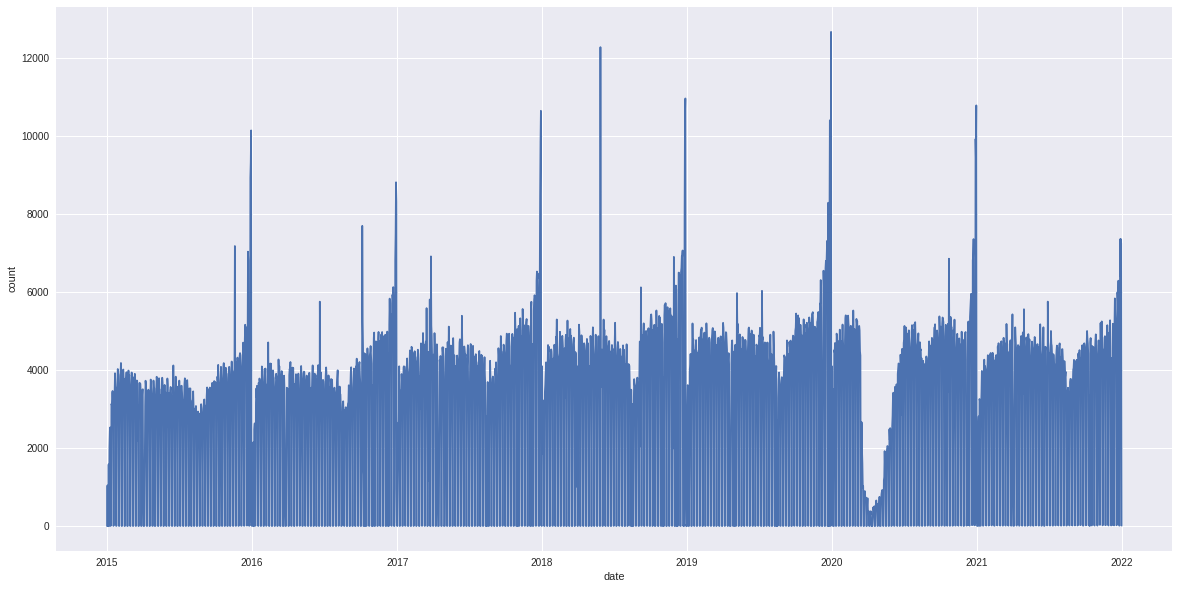

In [33]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=result_dgt, x='date', y='count', ax=ax)

Para comparar nuestras predicciones con los valores reales, vamos a tomar un periodo de tiempo concreto, los últimos 4 meses del año 2021 (mostraremos los 5 últimos)

<AxesSubplot:xlabel='date', ylabel='count'>

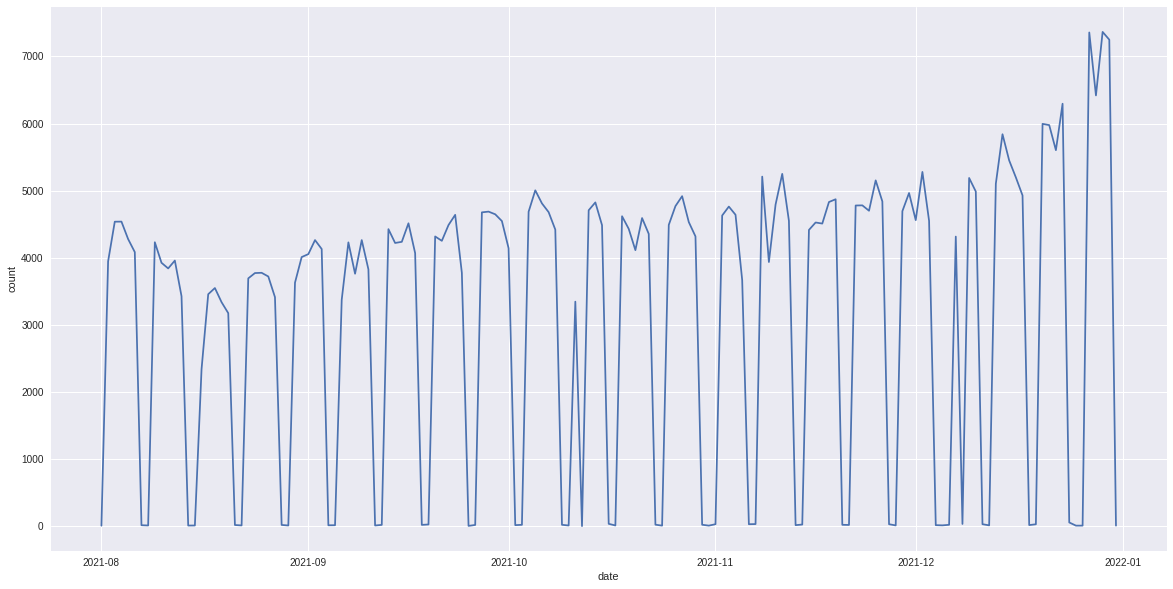

In [34]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=result_dgt[result_dgt['date'] >= '2021-08-01' ], x='date', y='count', ax=ax)

Definiremos los campos predictores como el campo a predecir, pero añadiremos la fecha en ambos para realizar el corte de los últimos 4 meses

In [35]:
X = result_dgt[[
    'date', 'is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year'
]]

y = result_dgt[['date','count']]

In [36]:
X

,date,is_weekend,s_period_week,s_period_week,s_period_year,c_period_week,c_period_week,c_period_year
FEC_TRAMITE,,,,,,,,
2015-01-01,2015-01-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000
2015-01-02,2015-01-02,0.0,7.818315e-01,7.818315e-01,1.721336e-02,0.623490,0.623490,0.999852
2015-01-03,2015-01-03,1.0,9.749279e-01,9.749279e-01,3.442161e-02,-0.222521,-0.222521,0.999407
2015-01-04,2015-01-04,1.0,4.338837e-01,4.338837e-01,5.161967e-02,-0.900969,-0.900969,0.998667
2015-01-05,2015-01-05,0.0,-4.338837e-01,-4.338837e-01,6.880243e-02,-0.900969,-0.900969,0.997630
...,...,...,...,...,...,...,...,...
2020-02-16,2020-02-16,1.0,-4.338837e-01,-4.338837e-01,-5.161967e-02,-0.900969,-0.900969,0.998667
2020-02-22,2020-02-22,1.0,-9.749279e-01,-9.749279e-01,-3.442161e-02,-0.222521,-0.222521,0.999407
2020-03-01,2020-03-01,1.0,-7.818315e-01,-7.818315e-01,-1.721336e-02,0.623490,0.623490,0.999852


Obtenemos los datos de entrenamiento y los de test (los últimos 4 meses)

In [38]:
train_X = X[X['date'] < '2021-09-01']
test_X = X[X['date'] >= '2021-09-01']

train_y = y[y['date'] < '2021-09-01']
test_y = y[y['date'] >= '2021-09-01']

Y, luego de ello, eliminamos la columna de fecha

In [39]:
X = X[['is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year']]
y = y['count']

train_X = train_X[['is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year']]
test_X = test_X[['is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year']]

train_y = train_y['count']
test_y = test_y['count']

Realizaremos las predicciones usando un RandomForestRegressor. Primero realizaremos una predicción con unos metadatos al azar para ver como se comporta nuestro modelo

In [40]:
rf = RandomForestRegressor(n_estimators=600, min_samples_split=5, oob_score=True, max_depth=5)
rf.fit(train_X, train_y)

RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=600,
                      oob_score=True)

In [41]:
rf.oob_score_

0.7234346012365651

In [42]:
rf.predict(train_X)

array([3000.80666479, 3539.60277932,    6.5631897 , ...,    7.20393965,
          7.66103104,    6.72973453])

In [43]:
y_hat = rf.predict(test_X)

test_score = r2_score(test_y, y_hat)


print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')

Out-of-bag R-2 score estimate: 0.723
Test data R-2 score: 0.747


In [44]:
from sklearn.model_selection import cross_val_score

cross_val_score(X=train_X,y=train_y, estimator=rf )

array([0.59392795, 0.73454389, 0.62999101, 0.51847663, 0.82922241])

LLega el turno de usar un GridSearchCV para comprobar que configuración de nuestro modelo tiene mejores predicciones

In [45]:
grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_leaf_nodes': [5,10,25,50,100]
}


grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    scoring="neg_mean_squared_error",
    verbose=2
)

In [46]:
grid_search.fit(train_X,train_y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_sp

[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=400; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=400; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=400; total time=   0.7s
[CV] END max_depth=5

[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END m

[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END 

[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=400; total time=   0.9s
[CV] END m

[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   0.9s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END m

[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=10, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=10, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=200; total time=   0.5s


[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s


[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=500; total time=   0.9s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=500; total time=   0.9s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=500; total time=   0.9s
[CV] END m

[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=200; total time=   0.4s


[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=300; total time=   0.6s


[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s


[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.6s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=2, n_estimators=100; total time=

[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=6, n_estimators=500; total time=   1.5s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s


[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=400; total tim

[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=500; total time=   1.6s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=500;

[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END m

[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=300; total time=   0.6s


[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total tim

[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=400; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=400; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=400; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.2s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.2s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.2s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.3s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.3s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=8, n_estimators=100; total time=   0.2s


[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.6s


[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=400; total tim

[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=300; total time=   1.1s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.3s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.3s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.4s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.4s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=500; total time=   1.7s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=500; total time=   1.7s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=500; total tim

[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END m

[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=300; total time=   0.6s


[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.9s


[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=400; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=400; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=400; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=4, n_estimators=100; total time=   0.2s


[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=8, n_estimators=500; total time=   1.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time

[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.8s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=400; total time=   1.1s


[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=500; total tim

[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.6s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.6s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.8s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; tota

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_leaf_nodes': [5, 10, 25, 50, 100],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [47]:
grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 5,
 'min_samples_split': 4,
 'n_estimators': 100}

In [48]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.184942,0.005647,0.009301,0.000652,5,5,2,100,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-1.267146e+06,-9.571088e+05,-1.804979e+06,-2.318870e+06,-8.974352e+05,-1.449108e+06,540859.605131,55
1,0.359803,0.005784,0.016401,0.000530,5,5,2,200,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-1.268483e+06,-9.577534e+05,-1.798480e+06,-2.322208e+06,-9.069974e+05,-1.450784e+06,538941.455915,76
2,0.533391,0.007627,0.023356,0.000098,5,5,2,300,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-1.261210e+06,-9.532702e+05,-1.803364e+06,-2.300333e+06,-9.030573e+05,-1.444247e+06,534657.795603,4
3,0.710227,0.009634,0.030573,0.000135,5,5,2,400,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-1.265748e+06,-9.572805e+05,-1.808694e+06,-2.310568e+06,-9.007536e+05,-1.448609e+06,538074.510531,50
4,0.892097,0.018879,0.037869,0.000151,5,5,2,500,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-1.263851e+06,-9.480589e+05,-1.803009e+06,-2.303098e+06,-9.078165e+05,-1.445167e+06,535319.237325,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.332400,0.016378,0.011284,0.000243,20,100,10,100,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-1.283773e+06,-1.219263e+06,-2.106144e+06,-2.590112e+06,-1.029945e+06,-1.645848e+06,599318.821416,454
496,0.649041,0.020390,0.020550,0.000362,20,100,10,200,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-1.287626e+06,-1.207946e+06,-2.095306e+06,-2.585319e+06,-1.023549e+06,-1.639949e+06,598628.816904,450
497,0.946780,0.045888,0.030645,0.001031,20,100,10,300,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-1.279190e+06,-1.204190e+06,-2.130953e+06,-2.570889e+06,-1.006916e+06,-1.638428e+06,604729.280269,448
498,1.412491,0.131612,0.041797,0.001531,20,100,10,400,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-1.277437e+06,-1.195767e+06,-2.122562e+06,-2.568646e+06,-1.003695e+06,-1.633621e+06,604768.625785,442


Con la configuración óptima, volvemos a crear un nuevo modelo para tomar mediciones

In [49]:
rf_final = RandomForestRegressor(n_estimators=200, min_samples_split=2, oob_score=True, max_depth=5, max_leaf_nodes=5)
rf_final.fit(train_X, train_y)

RandomForestRegressor(max_depth=5, max_leaf_nodes=5, n_estimators=200,
                      oob_score=True)

In [50]:
rf_final.oob_score_

0.7254368167609848

Y hacemos una comparativa de resultados con el primer modelo

In [51]:
y_hat = rf_final.predict(test_X)

test_score = r2_score(test_y, y_hat)


print(f'Out-of-bag R-2 score estimate: {rf_final.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')

Out-of-bag R-2 score estimate: 0.725
Test data R-2 score: 0.729


In [52]:
cross_val_score(X=train_X,y=train_y, estimator=rf_final )

array([0.59963773, 0.7508492 , 0.63724372, 0.53617176, 0.83566322])

In [53]:
y_hat = rf.predict(test_X)

test_score = r2_score(test_y, y_hat)


print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')

Out-of-bag R-2 score estimate: 0.723
Test data R-2 score: 0.747


In [54]:
cross_val_score(X=train_X,y=train_y, estimator=rf )

array([0.59240866, 0.73440009, 0.62888679, 0.51886402, 0.83051508])

Si bien los resultados son mejores, esa mejoría es apenas perceptible en los resultados

Llega el momento de hacer una comparación entre nuestras predicciones y la realidad

In [55]:
df_graph_final = test_X.copy()

In [56]:
df_graph_final.sample(10)

,is_weekend,s_period_week,s_period_week,s_period_week,s_period_week,s_period_year,c_period_week,c_period_week,c_period_week,c_period_week,c_period_year
FEC_TRAMITE,,,,,,,,,,,
2021-11-04,0.0,-7.818315e-01,-7.818315e-01,-7.818315e-01,-7.818315e-01,0.128748,0.623490,0.623490,0.623490,0.623490,-0.991677
2021-12-15,0.0,-9.749279e-01,-9.749279e-01,-9.749279e-01,-9.749279e-01,-0.545240,-0.222521,-0.222521,-0.222521,-0.222521,-0.838280
2021-11-23,0.0,-4.338837e-01,-4.338837e-01,-4.338837e-01,-4.338837e-01,-0.196673,-0.900969,-0.900969,-0.900969,-0.900969,-0.980469
2021-10-25,0.0,4.338837e-01,4.338837e-01,4.338837e-01,4.338837e-01,0.296713,-0.900969,-0.900969,-0.900969,-0.900969,-0.954967
2021-09-15,0.0,-9.749279e-01,-9.749279e-01,-9.749279e-01,-9.749279e-01,0.835925,-0.222521,-0.222521,-0.222521,-0.222521,-0.548843
2021-12-14,0.0,-4.338837e-01,-4.338837e-01,-4.338837e-01,-4.338837e-01,-0.530730,-0.900969,-0.900969,-0.900969,-0.900969,-0.847541
2021-11-10,0.0,-9.749279e-01,-9.749279e-01,-9.749279e-01,-9.749279e-01,0.025818,-0.222521,-0.222521,-0.222521,-0.222521,-0.999667
2021-12-31,0.0,-1.842215e-13,-1.842215e-13,-1.842215e-13,-1.842215e-13,-0.752667,1.000000,1.000000,1.000000,1.000000,-0.658402
2021-12-27,0.0,4.338837e-01,4.338837e-01,4.338837e-01,4.338837e-01,-0.705584,-0.900969,-0.900969,-0.900969,-0.900969,-0.708627


In [57]:
df_graph_final['date'] = df_graph_final.index

In [58]:
df_graph_final.sample(10)

,is_weekend,s_period_week,s_period_week,s_period_week,s_period_week,s_period_year,c_period_week,c_period_week,c_period_week,c_period_week,c_period_year,date
FEC_TRAMITE,,,,,,,,,,,,
2021-11-18,0.0,-0.781831,-0.781831,-0.781831,-0.781831,-0.111659,0.623490,0.623490,0.623490,0.623490,-0.993747,2021-11-18
2021-10-19,0.0,-0.433884,-0.433884,-0.433884,-0.433884,0.393590,-0.900969,-0.900969,-0.900969,-0.900969,-0.919286,2021-10-19
2021-10-09,1.0,0.781831,0.781831,0.781831,0.781831,0.545240,0.623490,0.623490,0.623490,0.623490,-0.838280,2021-10-09
2021-11-06,1.0,0.781831,0.781831,0.781831,0.781831,0.094537,0.623490,0.623490,0.623490,0.623490,-0.995521,2021-11-06
2021-09-02,0.0,-0.781831,-0.781831,-0.781831,-0.781831,0.936881,0.623490,0.623490,0.623490,0.623490,-0.349647,2021-09-02
2021-12-02,0.0,-0.781831,-0.781831,-0.781831,-0.781831,-0.345612,0.623490,0.623490,0.623490,0.623490,-0.938377,2021-12-02
2021-09-25,1.0,0.781831,0.781831,0.781831,0.781831,0.729558,0.623490,0.623490,0.623490,0.623490,-0.683919,2021-09-25
2021-09-30,0.0,-0.781831,-0.781831,-0.781831,-0.781831,0.668064,0.623490,0.623490,0.623490,0.623490,-0.744104,2021-09-30
2021-09-19,1.0,0.974928,0.974928,0.974928,0.974928,0.796183,-0.222521,-0.222521,-0.222521,-0.222521,-0.605056,2021-09-19


In [59]:
df_graph_final['count'] = rf_final.predict(test_X)

<AxesSubplot:xlabel='date', ylabel='count'>

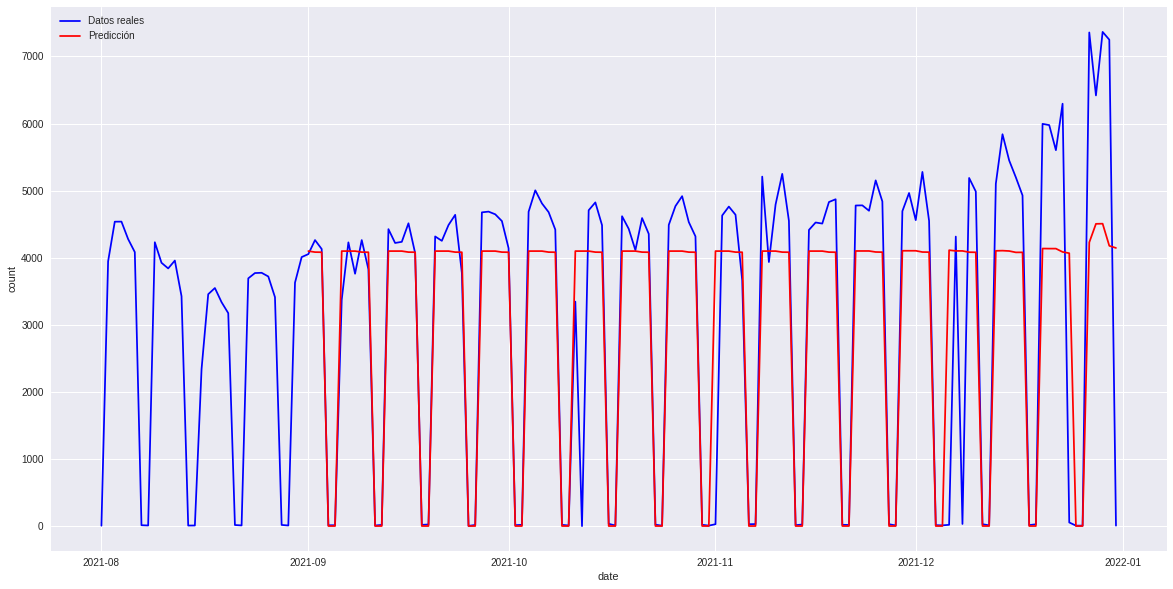

In [60]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=result_dgt[result_dgt['date'] >= '2021-08-01' ], x='date', y='count', ax=ax, color='blue', label='Datos reales')
sns.lineplot(data=df_graph_final, x='date', y='count', ax=ax, color='red', label='Predicción')

## Conclusiones

- El modelo consigue predecir el descenso de transacciones los fines de semana
- Dependiendo de las iteraciones, consigue o no el aumento al final de año (esto puede ser debido al fracionamiento de los datos, ya que a cada generación se trae un porcentaje bajo de los mismo, pero a un volumen mayor el kernel se satura)